# Surrogate analysis for the LST timeseries at the lake buoys

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import sqrt, append, isnan
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
#from matplotlib import colorbar, colors
#import cmocean
#import cartopy.crs as crs
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.nn_regression import make_nn_surrogate_model
from surrogate.pc_regression import make_pc_surrogate_model
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens
from calibration.bayesian_optimization import run_bayesian_optimization

### Set the variables to analyze and get list of filenames

In [3]:
# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
all_output_filename = '../output/wfv_buoy_temperatures_all_processed.pkl'

## Load inputs 

In [5]:
## parameter info

# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [6]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

In [7]:
## data info

#load the training data
with open(all_output_filename, 'rb') as fp:
    set_dict = pickle.load(fp)
    print('Done loading from binary file')
    
train_dict = set_dict['training_set']
test_dict = set_dict['test_set']
bo_dict = set_dict['bo_set']

Done loading from binary file


In [8]:
# Get and check train sizes
nens = len(train_dict['run_numbers'])
ntime = train_dict['model_data_timeseries']['time'].shape[0]
nens_, ntime_ = train_dict['model_data_timeseries']['model']['LST'].shape
ntime__ = train_dict['model_data_timeseries']['data']['LST'].shape[0]
nens__, ndim = variable_matrix_train.shape

# sanity check
assert(ntime==ntime_)
assert(ntime==ntime__)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
Timeseries size : 18136


In [9]:
# Get and check test sizes
nens = len(test_dict['run_numbers'])
ntime = test_dict['model_data_timeseries']['time'].shape[0]
nens_, ntime_ = test_dict['model_data_timeseries']['model']['LST'].shape
ntime__ = test_dict['model_data_timeseries']['data']['LST'].shape[0]
nens__, ndim = variable_matrix_test.shape

# sanity check
assert(ntime==ntime_)
assert(ntime==ntime__)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
Timeseries size : 18136


##  Construct surrogate models

In [10]:
# some variables for surrogate
var_explained = 0.9 #for PCA

# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
if hot_encode:
    train_x = variable_matrix_train
    test_x = variable_matrix_test
else:
    train_x = ptrain
    test_x = ptest

# PC surrogate model parameters
polynomial_order = 2
regression_type = 'ElasticNet'

# NN surrogate model parameters
batch_size = int(nens/5)
hidden_layers = 1
learn_rate = 0.00005
nepochs=2000

# randomization
random_seed = 222
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

# initialize the surrogate dictionary
kl_surrogate = dict()

### Decompose the time series

In [11]:
# Decompose the timeseries using PCA/KL
pca_obj = PCA(n_components=var_explained, random_state=random_seed, whiten=True)
pca_obj.fit(train_dict['model_data_timeseries']['model']['LST'])

PCA(n_components=0.9, random_state=222, whiten=True)

In [12]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(train_dict['model_data_timeseries']['model']['LST'])
klxi_test  = pca_obj.transform(test_dict['model_data_timeseries']['model']['LST'])
eigenratio = pca_obj.explained_variance_ratio_
neig = pca_obj.n_components_
print(f'number of eigenmodes is {neig}')

number of eigenmodes is 8


### Train and check the PC model

In [13]:
# Polynomial Chaos
kl_surrogate['PC'] = make_pc_surrogate_model(
    train_x, klxi_train, polynomial_order=polynomial_order, regressor=regression_type,
)   

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


poly shape: (8,)
parameter common shape: (18,)
output shape: (8, 18)


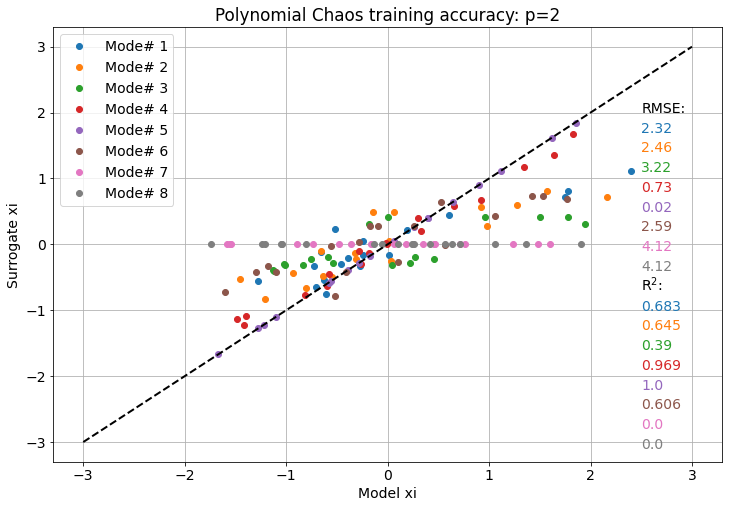

poly shape: (8,)
parameter common shape: (5,)
output shape: (8, 5)


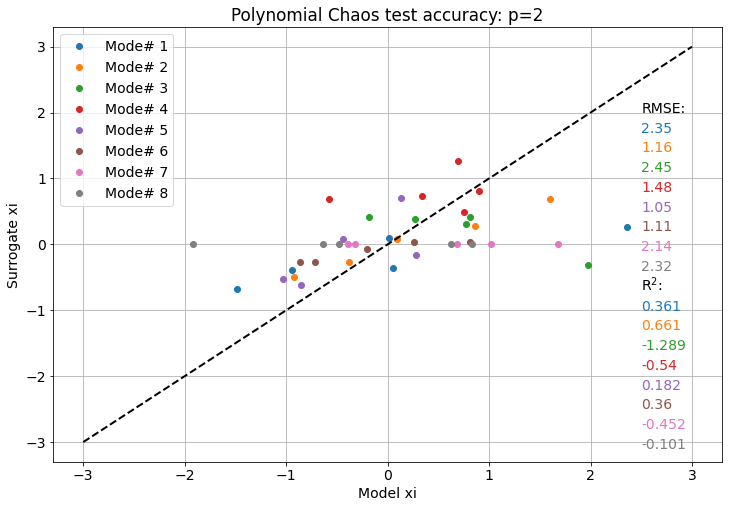

In [14]:
# Checking PC accuracy in KL space
rmse_v = 2
r2_v = -0.7
for ii in [0,1]:
    if ii == 0:
        comparison = 'training'
        klxi_pred = surrogate_model_predict(kl_surrogate['PC'],train_x)
        klxi_model = klxi_train
    else:
        comparison = 'test'
        klxi_pred = surrogate_model_predict(kl_surrogate['PC'],test_x)
        klxi_model = klxi_test
    fig = plt.figure(figsize=(12,8))
    plt.text(2.5,rmse_v,'RMSE:')
    plt.text(2.5,r2_v,'R$^2$:')
    for iout in range(neig):
        py = plt.plot(klxi_model[:,iout], klxi_pred[:, iout], 'o',label=f'Mode# {iout+1}')
        rmse = sqrt(sum((klxi_pred[:, iout] - klxi_model[:,iout])**2))
        u = ((klxi_model[:,iout] - klxi_pred[:, iout])**2).sum()
        v = ((klxi_model[:,iout] - klxi_model[:,iout].mean())**2).sum()
        r2 = 1 - u/v
        plt.text(2.5,rmse_v-(iout+1)*0.3,str(round(rmse,2)),color=py[0].get_color())
        plt.text(2.5,r2_v-(iout+1)*0.3,str(round(r2,3)),color=py[0].get_color())
    plt.plot([-3,3], [-3,3], 'k--', lw=2)
    plt.xlabel('Model xi')
    plt.ylabel('Surrogate xi')
    plt.title(f'Polynomial Chaos {comparison} accuracy: p={polynomial_order}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

### Train and check the NN model

In [ ]:
# Neural Network
kl_surrogate['NN'] = make_nn_surrogate_model(
    train_x.values, klxi_train,
    test_X=test_x.values, test_Y=klxi_test,
    num_hidden_layers=hidden_layers,
    lrate=learn_rate,
    batch_size=batch_size,
    nepochs=nepochs,
    seed=random_seed,
    eigenratio=eigenratio,
)

   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1         18   1.797632   0.869947   1.247715     1.247715(0)   0.000050
       100       1800   0.382725   0.705989   1.102444     1.102444(99)   0.000050
       200       3600   0.239757   0.586984   1.010931     1.010931(199)   0.000050
       300       5400   0.227285   0.496689   0.930197     0.930197(299)   0.000050
       400       7200   0.293742   0.430581   0.855864     0.855847(399)   0.000050
       500       9000   0.269597   0.380383   0.794200     0.793719(498)   0.000050
       600      10800   0.260371   0.341298   0.747300     0.746386(598)   0.000050
       700      12600   0.149928   0.308468   0.706996     0.706632(699)   0.000050
       800      14400   0.377754   0.278636   0.678853     0.678509(797)   0.000050
       900      16200   0.197706   0.251055   0.658674     0.657994(898)   0.000050


In [ ]:
# Checking NN accuracy in KL space
rmse_v = 2
r2_v = -0.7
for ii in [0,1]:
    if ii == 0:
        comparison = 'training'
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        klxi_model = klxi_train
    else:
        comparison = 'test'
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        klxi_model = klxi_test
    fig = plt.figure(figsize=(12,8))
    plt.text(2.5,rmse_v,'RMSE:')
    plt.text(2.5,r2_v,'R$^2$:')
    for iout in range(neig):
        py = plt.plot(klxi_model[:,iout], klxi_pred[:, iout], 'o',label=f'Mode# {iout+1}')
        rmse = sqrt(sum((klxi_pred[:, iout] - klxi_model[:,iout])**2))
        u = ((klxi_model[:,iout] - klxi_pred[:, iout])**2).sum()
        v = ((klxi_model[:,iout] - klxi_model[:,iout].mean())**2).sum()
        r2 = 1 - u/v
        plt.text(2.5,rmse_v-(iout+1)*0.3,str(round(rmse,2)),color=py[0].get_color())
        plt.text(2.5,r2_v-(iout+1)*0.3,str(round(r2,3)),color=py[0].get_color())
    plt.plot([-3,3], [-3,3], 'k--', lw=2)
    plt.xlabel('Model xi')
    plt.ylabel('Surrogate xi')
    plt.title(f'Neural Network {comparison} accuracy: hidden layers={hidden_layers}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

## Global Sensitivity Analysis

### GSA on PC model

In [ ]:
# get the sensitivity for the PC surrogate
sens_eig_sobol = compute_sensitivities(kl_surrogate['PC'], train_x, sample_size=10000)

total_var_sens = {'main': [], 'total': []}
for sens_label in ['main','total']:
    print(sens_label)
    portion_of_eigen_explain = sens_eig_sobol[sens_label]/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
    portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
    total_var_sens[sens_label] = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)

In [ ]:
# Plot eigenmode sensitivities for PC
case_labels = [rf'$\xi_{str(j+1)}$ [ {eigenratio[j]:.3f} ]' for j in range(neig)]
case_labels.append(r'$\xi_{ALL}$')
plot_sens(append(sens_eig_sobol['main'],total_var_sens['main'].reshape(1,-1),axis=0),
          range(len(variables)),range(neig+1),vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=2,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

plot_sens(append(sens_eig_sobol['total'],total_var_sens['total'].reshape(1,-1),axis=0),
          range(len(variables)),range(neig+1),vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=2,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

# Plot overall sensitivities by param
case_labels = [r'$\xi_{ALL}$']
plot_sens(total_var_sens['main'].reshape(1,-1),
          range(len(variables)),[0],vis="bar",reverse=True,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=1,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=10, xticklabel_rotation=60) 

plot_sens(total_var_sens['total'].reshape(1,-1),
          range(len(variables)),[0],vis="bar",reverse=True,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=1,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=10, xticklabel_rotation=60) 

### GSA on NN model

In [ ]:
# get the sensitivity for the PC surrogate
sens_eig_sobol = compute_sensitivities(kl_surrogate['NN'], train_x, sample_size=10000)

total_var_sens = {'main': [], 'total': []}
for sens_label in ['main','total']:
    portion_of_eigen_explain = sens_eig_sobol[sens_label]/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
    portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
    total_var_sens[sens_label] = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)

In [ ]:
# Plot eigenmode sensitivities for NN
case_labels = [rf'$\xi_{str(j+1)}$ [ {eigenratio[j]:.3f} ]' for j in range(neig)]
case_labels.append(r'$\xi_{ALL}$')
plot_sens(append(sens_eig_sobol['main'],total_var_sens['main'].reshape(1,-1),axis=0),
          range(len(variables)),range(neig+1),vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=2,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

plot_sens(append(sens_eig_sobol['total'],total_var_sens['total'].reshape(1,-1),axis=0),
          range(len(variables)),range(neig+1),vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=2,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

# Plot overall sensitivities by param
case_labels = [r'$\xi_{ALL}$']
plot_sens(total_var_sens['main'].reshape(1,-1),
          range(len(variables)),[0],vis="bar",reverse=True,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=1,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=10, xticklabel_rotation=60) 

plot_sens(total_var_sens['total'].reshape(1,-1),
          range(len(variables)),[0],vis="bar",reverse=True,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=1,legend_size=25,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=10, xticklabel_rotation=60) 